# **NFT COLLABOT**

> Summary Value Prop Blog

*NFT CollaBot* is a project that designed by obtaining requirements of NFT ecosystem. NFT marketplace from Tezos ecosystem named objkt.com will be starting point of the project. NFT CollaBot aims to make underrated artists more visible.

In [ ]:
# importing libraries for data process
import pandas as pd
import numpy as np

# importing libraries to handle web scraping
import requests
import json

# string operations will be handled during data analysis
import re
import string
from io import StringIO

# also using these libraries
import random
import time

### API DOCUMENTATION

Objktcom has a published API documentation
*https://data.objkt.com/docs/#listing*

Documentation points GraphiQL explore page to try queries.
There is a link below that explains how to write queries with GraphiQL
*https://graphql.org/learn/queries/*

Besides, there is a useful link to code on Python using GraphiQL queries. Check the following link:
*https://towardsdatascience.com/connecting-to-a-graphql-api-using-python-246dda927840*

In [ ]:
# objktcom api endpoint will be used for several times to evaluate queries

api_endpoint = 'https://data.objkt.com/v2/graphql'

> ##### GRAPHIQL
GraphiQL playground is useful tool to understand insight of the query format
>  https://data.objkt.com/explore/

> #### Retrieve Beginning Primary Key Value

There are thousands of NFTs belongs to a tag. It will take too long to get all of the data. Besides, it will be more effective to show newer NFTs to achieve main target of the project.

The mechanism have to use token_pk to request data, according to API constrains. Decided to choose a token_pk using a timestamp.

In [ ]:
# query for getting primary key has evaluated below:

#initial_token_pk_query="""query {
#    token(where: {timestamp: {_gt: "2022-06-15T00:12:00+00:00"}}, limit: 1) {
#    creators {
#        token_pk
#    }
#    }
#}"""

"""
# send request
token_pk_data = requests.post(api_endpoint, json={'query': initial_token_pk_query})
token_pk_data = json.loads(token_pk_data.text)
token_pk_data=token_pk_data['data']['token']

# output is 8682680
# this primary key will be used in the next steps of the development
"""

### RECURSIVE MECHANISM TO GET TOKEN PRIMARY KEY DATA

After getting primary key of the starting point, query for tag of token will be evaluated. In this query, only primary keys of tokens will be requested from API. Then, this primary key value will be used to get information about related NFT. This mechanism aims to implement request process recursively.

In [ ]:
counter=[0]      # counts how many times has the function is executed

def request_nft_token_pk(tag_name_variable):
      if counter[0]>0:global pk_value
      if counter[0]==0: pk_value=8682680

      # declare query to request data from api
      nftToken_pk_query="""query {
      token_tag(where: {tag: {name: {_eq: tag_name_variable}}, _and: {token_pk: {_gt: last_pk_value}}}) {
      token_pk
      }
      }"""
      #create dynamic query to request recursively
      nftToken_pk_query=nftToken_pk_query.replace("tag_name_variable",tag_name_variable)
      nftToken_pk_query=nftToken_pk_query.replace("last_pk_value",str(pk_value))

      #request data from objkt.com api endpoint
      token_pk_request = requests.post(api_endpoint, json={'query': nftToken_pk_query})
      token_pk_request = json.loads(token_pk_request.text)
      token_pk_request=token_pk_request['data']['token_tag']

      #have to assign a boolean variable to check is response empty or not
      isEmpty_response=False

      if counter[0]>0:                       # to avoid unbound local error...
            global primaryKey_df             # ...declare as global
            global primaryKey_df_loop

      if counter[0]==0 :
            primaryKey_df = pd.DataFrame()
            primaryKey_df_loop = pd.DataFrame()
      primaryKey_df_loop = pd.DataFrame(token_pk_request)            # convert json data into a data frame
      primaryKey_df=pd.concat([primaryKey_df,primaryKey_df_loop])    # concatenate two data frames to save all data in one data frame


      if primaryKey_df_loop.shape[0]>0:         # assign latest primary key value to a new variable to use this value for recursion queries
            pk_value=int(primaryKey_df_loop.loc[(primaryKey_df_loop.shape[0])-1].values)
      else: isEmpty_response=True               # make boolean value True whenever response is empty

      # increase one the variable for each execution of recursive function
      counter[0]+=1

      # create recursive algorithm inside function
      if not isEmpty_response:     # execute the function since it does not retrieve any data from api endpoint
            #time.sleep(0.1)
            return request_nft_token_pk(tag_name_variable)

request_nft_token_pk("cartoon")

# arrange index of the data frame
primaryKey_df.set_index(np.arange(primaryKey_df.shape[0]))

### NFT Recommendation Mechanism

> **Random Recommendation**

Select an NFT randomly to perform functionality more fair for everyone

> **Future Aspects:**

On the other hand, this mechanism will be extended with an algorithm in further stages

There will be an input option to find underrated artists on ecosystem. The algorithm will recommend artists with low sales

In [ ]:
import random
randomNFT_index=random.sample(range(primaryKey_df.shape[0]),10)
randomNFT=primaryKey_df.iloc[randomNFT_index[0]]

print(randomNFT['token_pk'])

### Get NFT Info From API

In [ ]:
#queries must be evaluated for the chosen primary key

nft_info_query= """query{
  token(where: {pk: {_eq: "random_pk_value"}}) {
    name
    token_id
    mime
    supply
    artifact_uri
  }
}
"""

nft_link_query="""query{
  token(where: {pk: {_eq: "random_pk_value"}}) {
    fa {
      token_link
    }
  }
}
"""

nft_active_sale_query="""query{
  token(where: {pk: {_eq: "random_pk_value"}}) {
  	asks(where: {status: {_neq: "cancelled"}}) {
      price
      seller_address
      amount_left
      status
      timestamp
		}
  }
}"""

nft_creator_query="""query{
  token_creator(where: {token_pk: {_eq: "random_pk_value"}}) {
    creator_address
  }
}"""


# quick note...
# "tz1burnburnburnburnburnburnburjAYjjX" is address of burn address for the burned tokens
nft_collectors_query="""query{
  token(where: {pk: {_eq: "random_pk_value"}}) {
    holders{
      quantity
      holder_address
    }
  }
}"""

#replace variable with the primary key value
nft_info_query=nft_info_query.replace("random_pk_value",str(randomNFT['token_pk']))
nft_link_query=nft_link_query.replace("random_pk_value",str(randomNFT['token_pk']))
nft_active_sale_query=nft_active_sale_query.replace("random_pk_value",str(randomNFT['token_pk']))
nft_creator_query=nft_creator_query.replace("random_pk_value",str(randomNFT['token_pk']))
nft_collectors_query=nft_collectors_query.replace("random_pk_value",str(randomNFT['token_pk']))

In [ ]:
nft_info_request = requests.post(api_endpoint, json={'query': nft_info_query})
nft_info_request = json.loads(nft_info_request.text)
nft_info_request = nft_info_request['data']['token']

nft_link_request = requests.post(api_endpoint, json={'query': nft_link_query})
nft_link_request = json.loads(nft_link_request.text)
nft_link_request = nft_link_request['data']['token']

nft_active_sale_request = requests.post(api_endpoint, json={'query': nft_active_sale_query})
nft_active_sale_request = json.loads(nft_active_sale_request.text)
nft_active_sale_request = nft_active_sale_request['data']['token']

nft_creator_request = requests.post(api_endpoint, json={'query': nft_creator_query})
nft_creator_request = json.loads(nft_creator_request.text)
nft_creator_request = nft_creator_request['data']

nft_collectors_request = requests.post(api_endpoint, json={'query': nft_collectors_query})
nft_collectors_request = json.loads(nft_collectors_request.text)
nft_collectors_request = nft_collectors_request['data']['token']

In [ ]:
nft_info_df=pd.DataFrame(nft_info_request)   # convert into data frame
nft_info_df

> #### Generate NFT Link

In [ ]:
nft_link=nft_link_request[0]['fa']['token_link']                      # parse data
nft_link=nft_link.replace(":id",str(int(nft_info_df['token_id'][0]))) # replace a part of string with the token_id to complete url
nft_link

> #### Generate NFT Primary-Secondary Stats

In [ ]:
nft_active_sale_request=nft_active_sale_request[0]['asks']
nft_active_sale_request_df=pd.DataFrame(nft_active_sale_request)

In [ ]:
if nft_active_sale_request_df.empty is True: print("no active sale!")
else: print("Available")

> #### Generate Creator Info

In [ ]:
nft_creator_request=nft_creator_request['token_creator']
nft_creator_request=nft_creator_request[0]['creator_address']
nft_creator_request

>> #### TzKT API

TzKT API has an endpoint to get data of wallets on tezos ecosystem. Endpoint link:
>>>https://api.tzkt.io/

In the following stage, have to match creator address with the tezos ecosystem registered name

In [ ]:
import contextlib
def artist_info(wallet_address_input):
    account_data_url=f"https://api.tzkt.io/v1/accounts/{wallet_address_input}"        # tzkt.io API endpoint
    response = requests.get(account_data_url)                                   # send request to get data

    with contextlib.suppress(KeyError or json.decoder.JSONDecodeError):
        response=response.json()
        print("Owner of the wallet address is "+response['alias'])       # printing username of account owner to see function is whether working or not

    account_metadata_url=f"https://api.tzkt.io/v1/accounts/{wallet_address_input}/metadata"        # tzkt.io API endpoint
    response = requests.get(account_metadata_url)                                                  # send request to get data

    try:
        response=response.json()
        if(len(response['instagram'])):
            print("https://www.instagram.com/"+response['instagram']+"/")
    except json.decoder.JSONDecodeError:pass
    except KeyError:                                 # program gets KeyError when relevant metadata does not available for the user
        print("instagram is null")                   # print to test null case, only for validating the code


    # get twitter username from metadata, if exists on metadata
    try:
        response=response.json()
        if(len(response['twitter'])):
            print("https://www.twitter.com/"+response['twitter'])
    except json.decoder.JSONDecodeError:pass
    except AttributeError:
        if(len(response['twitter'])):
            print("https://www.twitter.com/"+response['twitter'])
    except KeyError:print("Twitter is null")


artist_info(nft_creator_request)

### Request Artist Info for Stats From API



> All NFTs of a Creator

In [ ]:
# evaluate a recursive function for it

counterN=[0]
def creator_all_NFTs(wallet_address):
    if counterN[0]>0:global nft_pk_val
    if counterN[0]==0:nft_pk_val=0

    creator_allNFT_query="""query{
        listing(where: {token: {creators: {creator_address: {_eq: "wallet_address"}, token_pk: {_gt: "nft_pk_val"}}}}, distinct_on: token_pk) {
        token {
            pk
            name
        }
    }
    }"""
    creator_allNFT_query = creator_allNFT_query.replace("nft_pk_val",str(nft_pk_val))
    creator_allNFT_query = creator_allNFT_query.replace("wallet_address",str(wallet_address))

    creator_all_nft_pk = requests.post(api_endpoint, json={'query': creator_allNFT_query})
    creator_all_nft_pk = json.loads(creator_all_nft_pk.text)
    creator_all_nft_pk = creator_all_nft_pk['data']['listing']

    if counterN[0]>0:
        global all_NFTs_df
        global loop_NFTs_df
    if counterN[0]==0:
        all_NFTs_df=pd.DataFrame()
        loop_NFTs_df=pd.DataFrame()
    for x in range(len(creator_all_nft_pk)):loop_NFTs_df=loop_NFTs_df.append(creator_all_nft_pk[x]['token'],ignore_index=True)
    loop_NFTs_df['pk']=loop_NFTs_df['pk'].astype(int)

    all_NFTs_df=pd.concat([all_NFTs_df,loop_NFTs_df])

    counterN[0]+=1

    if len(creator_all_nft_pk)==500:  # max retrieves are 500, if less there are no more data to response from api
        nft_pk_val=int(loop_NFTs_df['pk'][498])
        return creator_all_NFTs(wallet_address)
    else:
        print(f"Creator has {len(all_NFTs_df)} NFT has been created totally so far.")
        #print(all_NFTs_df)


# to see how function works, used my wallet address
creator_all_NFTs("tz1UX8qs6uR1Hro9QLiydGioxavxAHn3V5Za")


> Available Primary Sales

In [ ]:
# request primary sale NFTs info from a creator
# as an example, used my wallet address to see my NFTs
# this query requests only active primary sales from NFT creators because seller address attribute has same input with creator address...
# ...and status is Active

creator_nft_primaryNFT_info_query="""query{
  listing(where: {seller_address: {_eq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}, status: {_eq: "active"}, token: {creators: {creator_address: {_eq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}}}) {
    token {
      name
      pk
      supply
    }
  }
}"""

creator_primary_nft_pk = requests.post(api_endpoint, json={'query': creator_nft_primaryNFT_info_query})
creator_primary_nft_pk = json.loads(creator_primary_nft_pk.text)
creator_primary_nft_pk = creator_primary_nft_pk['data']['listing']

creator_primary_nft_pk

# then use another query to find out how many pieces left on primary, or use "holders" attribute on query?

> All Sales [primary and secondary] of an Artist for His/Her Created NFTs

In [57]:
# sale history [for both primary and secondary] of the artists for their mints [created pieces]
# evaluate a recursive function for it

counter_N=[0]
def creator_all_NFT_sales(wallet_address):
    if counter_N[0]>0:global nft_timestamp_val
    if counter_N[0]==0:nft_timestamp_val="2000-01-01T00:00:00+00:00" # initialize the timestamp value
    creator_all_sales_query="""query{
    listing_sale(where: {token: {creators: {creator_address: {_eq: "wallet_address"}}}, timestamp: {_gt: "nft_timestamp_val"}}, distinct_on: timestamp) {
        token_pk
        timestamp
        }
    }"""
    creator_all_sales_query = creator_all_sales_query.replace("nft_timestamp_val",str(nft_timestamp_val))
    creator_all_sales_query = creator_all_sales_query.replace("wallet_address",str(wallet_address))
    creator_all_sales_response= requests.post(api_endpoint, json={'query': creator_all_sales_query})
    creator_all_sales_response = json.loads(creator_all_sales_response.text)
    creator_all_sales_response = creator_all_sales_response['data']['listing_sale']

    if counter_N[0]>0:
        global all_NFT_sales_df
        global loop_NFT_sales_df
    if counter_N[0]==0:
        all_NFT_sales_df=pd.DataFrame()
        loop_NFT_sales_df=pd.DataFrame()

    #for x in range(len(creator_all_sales_response)):loop_NFT_sales_df=loop_NFT_sales_df.append(creator_all_sales_response[x],ignore_index=True)
    loop_NFT_sales_df = pd.DataFrame(creator_all_sales_response)

    loop_NFT_sales_df['token_pk']=loop_NFT_sales_df['token_pk'].astype(int)

    all_NFT_sales_df=pd.concat([ all_NFT_sales_df,loop_NFT_sales_df])
    counter_N[0]+=1

    # print(nft_timestamp_val)    # to check how it works

    if len(creator_all_sales_response)==500:  # max retrieves are 500, if less there are no more data to response from api
        nft_timestamp_val=str(loop_NFT_sales_df['timestamp'][499])
        return creator_all_NFT_sales(wallet_address)
    else:
        print(f"Creator has {len(all_NFT_sales_df)} NFT sale totally so far.")
        counter_N[0]=0

# enter a wallet address to pass a parameter
creator_all_NFT_sales("tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh")


Creator has 413 NFT sale totally so far.


> Only Primary Sales with Token Price

In [58]:
# sale history [for both primary and secondary] of the artists for their mints [created pieces]
# evaluate a recursive function for it

def creator_primary_NFT_sales(wallet_address):
    if counter_N[0]>0:global nft_timestamp_val
    if counter_N[0]==0:nft_timestamp_val="2000-01-01T00:00:00+00:00" # initialize the timestamp value
    creator_primary_sales_query="""{
    listing_sale(where: {token: {creators: {creator_address: {_eq: "wallet_address"}}}, timestamp: {_gt: "nft_timestamp_val"}, seller_address: {_eq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}, distinct_on: timestamp) {
        price
        token_pk
        buyer_address
        timestamp
        }
    }"""
    creator_primary_sales_query = creator_primary_sales_query.replace("nft_timestamp_val",str(nft_timestamp_val))
    creator_primary_sales_query = creator_primary_sales_query.replace("wallet_address",str(wallet_address))
    creator_primary_sales_response= requests.post(api_endpoint, json={'query': creator_primary_sales_query})
    creator_primary_sales_response = json.loads(creator_primary_sales_response.text)
    creator_primary_sales_response = creator_primary_sales_response['data']['listing_sale']

    if counter_N[0]>0:
        global all_primaryNFT_sales_df
        global loop_primaryNFT_sales_df
    if counter_N[0]==0:
        all_primaryNFT_sales_df=pd.DataFrame()
        loop_primaryNFT_sales_df=pd.DataFrame()

    loop_primaryNFT_sales_df = pd.DataFrame(creator_primary_sales_response)
    loop_primaryNFT_sales_df['token_pk']=loop_primaryNFT_sales_df['token_pk'].astype(int)
    loop_primaryNFT_sales_df['price']=loop_primaryNFT_sales_df['price'].astype(int)

    all_primaryNFT_sales_df=pd.concat([ all_primaryNFT_sales_df,loop_primaryNFT_sales_df])
    counter_N[0]+=1

    # print(nft_timestamp_val)    # to check how it works

    if len(creator_primary_sales_response)==500:  # max retrieves are 500, if less there are no more data to response from api
        nft_timestamp_val=str(loop_primaryNFT_sales_df['timestamp'][499])
        return creator_primary_NFT_sales(wallet_address)
    else:
        print(f"Creator has {len(all_primaryNFT_sales_df)} NFT sale on primary market totally so far.")
        counter_N[0]=0

# enter a wallet address to pass a parameter
creator_primary_NFT_sales("tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh")


Creator has 393 NFT sale on primary market totally so far.


In [59]:
# timestamp column includes both date and hour data together, splitting these two parameter in two different columns
all_primaryNFT_sales_df[['date','hour']]=all_primaryNFT_sales_df['timestamp'].str.split('T', expand=True)
del all_primaryNFT_sales_df['timestamp']

# deleting +00.00 at the ned of hour column. this symbolized gmt but unnecessary data for us
all_primaryNFT_sales_df['hour']=all_primaryNFT_sales_df['hour'].str.split('+', expand=True)

# manipulating price column to calculate exact value [as tezos] of a token
# dividing to 10^6
all_primaryNFT_sales_df['price']=pd.to_numeric(all_primaryNFT_sales_df['price'],downcast="float")
all_primaryNFT_sales_df['price']=all_primaryNFT_sales_df['price']/1000000


# month and year of the date will be processed individually, so splitting them as well
all_primaryNFT_sales_df[['year','month','day']]=all_primaryNFT_sales_df['date'].str.split('-', expand=True)
del all_primaryNFT_sales_df['date']
all_primaryNFT_sales_df


,price,token_pk,buyer_address,hour,year,month,day
0,0.5,12707809,tz1W7dt78vpTyZTNU4kfnMYnquco1GSBuarL,21:22:32,2021,10,26
1,0.5,12707809,tz1WRydHsHnew531jmD5jX5dKsCJCazZegTv,18:08:02,2021,10,27
2,0.5,12707809,tz1SnaG866juj1mRmy9pHPW8Mq7uL8DWGJra,14:47:02,2021,10,30
3,0.5,12707809,tz1N5w7PinpCkyA5PUv3BnKsSjbbc19G4shd,17:34:02,2021,10,30
4,0.1,2683991,tz1W7dt78vpTyZTNU4kfnMYnquco1GSBuarL,17:26:12,2021,10,31
...,...,...,...,...,...,...,...
388,1.2,15968299,tz1hbQatUr6FSUYdkhcuYDYu1TwK1do2a3Mm,11:05:29,2022,09,11
389,0.3,24113166,tz1hbQatUr6FSUYdkhcuYDYu1TwK1do2a3Mm,11:05:59,2022,09,11
390,1.2,15968299,tz1VkDRDJDHprEN6crgjCyfvpeghjxKtMjqV,11:14:14,2022,09,24
391,0.3,24113166,tz1MGT3D9KNgugNXTpKBP2UDysVyYWqziHjM,11:39:44,2022,10,01


In [60]:
primarySaleRevenue_byMonth=all_primaryNFT_sales_df.groupby(["year","month"]).sum()
del primarySaleRevenue_byMonth['token_pk']

primarySaleRevenue_byMonth

price
year month       
2021 10      2.60
     11      1.85
2022 01     12.20
     02     15.50
     03     16.00
     04     22.05
     05     16.80
     06     21.55
     07     65.45
     08     30.80
     09      5.10
     10      0.60

>> Visualize Primary Sale Data

<AxesSubplot:title={'center':'Revenue of the Artist on Primary Market by Month'}, xlabel='Month', ylabel='Revenue (by Tezos)'>

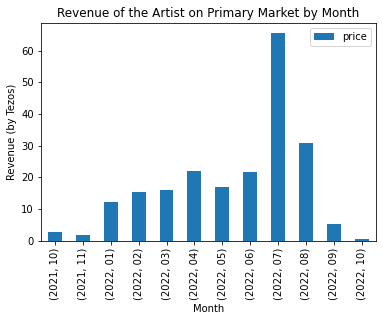

In [61]:
# use pandas data frame plot to visualize the data
primarySaleRevenue_byMonth.plot(kind='bar',title="Revenue of the Artist on Primary Market by Month",xlabel="Month",ylabel="Revenue (by Tezos)")

> Only secondary Sales of the Artist with Loyalties

In [ ]:
"""query secondary_sold {
  listing_sale(where: {token: {creators: {creator_address: {_eq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}}, seller_address: {_neq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}) {
    price
    token_pk
    token {
      royalties {
        amount
        # amount stands for percentage of the royalty
        # e.g. if amount is equal to 150, then creator royalty is %15 in secondary sale for the relevant token
      }
    }
  }
}
"""

In [63]:
# sale history [for both primary and secondary] of the artists for their mints [created pieces]
# evaluate a recursive function for it

def creator_secondary_NFT_sales(wallet_address):
    if counter_N[0]>0:global nft_timestamp_val
    if counter_N[0]==0:nft_timestamp_val="2000-01-01T00:00:00+00:00" # initialize the timestamp value
    creator_secondary_sales_query="""{
    listing_sale(where: {token: {creators: {creator_address: {_eq: "wallet_address"}}}, timestamp: {_gt: "nft_timestamp_val"}, seller_address: {_neq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}, distinct_on: timestamp) {
        price
        token_pk
        buyer_address
        timestamp
        }
    }"""
    creator_secondary_sales_query = creator_secondary_sales_query.replace("nft_timestamp_val",str(nft_timestamp_val))
    creator_secondary_sales_query = creator_secondary_sales_query.replace("wallet_address",str(wallet_address))
    creator_secondary_sales_response= requests.post(api_endpoint, json={'query': creator_secondary_sales_query})
    creator_secondary_sales_response = json.loads(creator_secondary_sales_response.text)
    creator_secondary_sales_response = creator_secondary_sales_response['data']['listing_sale']

    if counter_N[0]>0:
        global all_secondaryNFT_sales_df
        global loop_secondaryNFT_sales_df
    if counter_N[0]==0:
        all_secondaryNFT_sales_df=pd.DataFrame()
        loop_secondaryNFT_sales_df=pd.DataFrame()

    loop_secondaryNFT_sales_df = pd.DataFrame(creator_secondary_sales_response)
    loop_secondaryNFT_sales_df['token_pk']=loop_secondaryNFT_sales_df['token_pk'].astype(int)
    loop_secondaryNFT_sales_df['price']=loop_secondaryNFT_sales_df['price'].astype(int)

    all_secondaryNFT_sales_df=pd.concat([ all_secondaryNFT_sales_df,loop_secondaryNFT_sales_df])
    counter_N[0]+=1

    if len(creator_secondary_sales_response)==500:  # max retrieves are 500, if less there are no more data to response from api
        nft_timestamp_val=str(loop_secondaryNFT_sales_df['timestamp'][499])
        return creator_secondary_NFT_sales(wallet_address)
    else:
        print(f"Creator has {len(all_secondaryNFT_sales_df)} NFT sale on secondary market totally so far.")
        counter_N[0]=0

# enter a wallet address to pass a parameter
creator_secondary_NFT_sales("tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh")


Creator has 20 NFT sale on secondary market totally so far.


In [100]:
# sale history [for both primary and secondary] of the artists for their mints [created pieces]
# evaluate a recursive function for it

def creator_secondary_NFT_sales_demo(wallet_address):
    if counter_N[0]>0:global nft_timestamp_val
    if counter_N[0]==0:nft_timestamp_val="2000-01-01T00:00:00+00:00" # initialize the timestamp value

    creator_secondary_sales_query="""{
    listing_sale(where: {token: {creators: {creator_address: {_eq: "wallet_address"}}}, timestamp: {_gt: "nft_timestamp_val"}, seller_address: {_neq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}, distinct_on: timestamp) {
        price
        token_pk
        buyer_address
        timestamp
        }
    }"""

    creator_secondary_sales_royalties_query="""{
    listing_sale(where: {token: {creators: {creator_address: {_eq: "wallet_address"}}}, timestamp: {_gt: "nft_timestamp_val"}, seller_address: {_neq: "tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh"}}, distinct_on: timestamp) {
        token {
        royalties {
            amount
            }
        }
    }
    }"""


    def send_request_sales(query_input):                 # nested function to handle manipulating query and sending request to API
        query_input = query_input.replace("nft_timestamp_val",str(nft_timestamp_val))
        query_input = query_input.replace("wallet_address",str(wallet_address))

        global creator_secondary_sales_response          # avoid UnboundLocal Error
        creator_secondary_sales_response = requests.post(api_endpoint, json={'query': query_input})
        creator_secondary_sales_response = json.loads(creator_secondary_sales_response.text)
        creator_secondary_sales_response = creator_secondary_sales_response['data']['listing_sale']
        return creator_secondary_sales_response

    def send_request_royalties(query_input):
        query_input = query_input.replace("nft_timestamp_val",str(nft_timestamp_val))
        query_input = query_input.replace("wallet_address",str(wallet_address))

        global creator_secondary_royalties_response
        creator_secondary_royalties_response = requests.post(api_endpoint, json={'query': query_input})
        creator_secondary_royalties_response = json.loads(creator_secondary_royalties_response.text)
        creator_secondary_royalties_response = creator_secondary_royalties_response['data']['listing_sale']
        return creator_secondary_royalties_response

    send_request_sales(creator_secondary_sales_query)
    send_request_royalties(creator_secondary_sales_royalties_query)

    if counter_N[0]>0:
        global all_secondaryNFT_sales_df
        global loop_secondaryNFT_sales_df
        global secondaryNFT_royalties_df
    if counter_N[0]==0:
        all_secondaryNFT_sales_df=pd.DataFrame()
        loop_secondaryNFT_sales_df=pd.DataFrame()
        secondaryNFT_royalties_df=pd.DataFrame()

    loop_secondaryNFT_sales_df = pd.DataFrame(creator_secondary_sales_response)
    loop_secondaryNFT_sales_df['token_pk']=loop_secondaryNFT_sales_df['token_pk'].astype(int)
    loop_secondaryNFT_sales_df['price']=loop_secondaryNFT_sales_df['price'].astype(int)
    # loop data frame saves the data for each iteration of the recursive algorithm, it is temporary data source...
    # data frame starts with "all" includes all of the retrieved data, it is permanent data frame that loop data frame transports data
    all_secondaryNFT_sales_df=pd.concat([ all_secondaryNFT_sales_df,loop_secondaryNFT_sales_df])

    # handling royalties data table below
    secondaryNFT_royalties_df=pd.DataFrame(creator_secondary_royalties_response)
    secondaryNFT_royalties_df['token'] = secondaryNFT_royalties_df['token'] .astype(str)
    secondaryNFT_royalties_df['token'] = secondaryNFT_royalties_df['token'].str.replace(r"[a-zA-Z]",'')
    secondaryNFT_royalties_df['token'] = secondaryNFT_royalties_df['token'].str.replace(f'[{string.punctuation}]', '')

    counter_N[0]+=1

    if len(creator_secondary_sales_response)==500:  # max retrieves are 500, if less there are no more data to response from api
        nft_timestamp_val=str(loop_secondaryNFT_sales_df['timestamp'][499])
        return creator_secondary_NFT_sales(wallet_address)
    else:
        print(f"Creator has {len(all_secondaryNFT_sales_df)} NFT sale on secondary market totally so far.")
        counter_N[0]=0

# enter a wallet address to pass a parameter
creator_secondary_NFT_sales_demo("tz1YAZ5Vkyc1Gpdy342uT33FYYFhyn2v6ibh")


Creator has 20 NFT sale on secondary market totally so far.
